In [175]:
import sqlite3
import pandasql as ps

import pandas as pd
import numpy as np

import openpyxl

import plotnine as p9

import warnings
warnings.filterwarnings('ignore')

In [176]:
OUT_PATH = 'D:/fvs_calibration/data/interim'

In [177]:
#read in source tables 
DB_PATH = 'D:FIA/FIADB_CA.db'

con = sqlite3.connect(DB_PATH)
# grab NC stands
stands = pd.read_sql_query("select STAND_CN, STAND_ID, INV_YEAR, REGION, FOREST from FVS_STANDINIT_COND where VARIANT = 'NC'", con)

In [178]:
# scrape stand_id so remeasurement ids match
#stands['INV_YEAR'] = stands['INV_YEAR'].astype(int)
stands['STAND_ID'] = stands['STAND_ID'].str[0:3] + stands['STAND_ID'].str[10:]

In [179]:
# drop stands with no remeasurment data
stands = stands.sort_values(by=['STAND_ID', 'INV_YEAR', 'REGION', 'FOREST'])
remeasured_stands = stands[stands.duplicated(subset=['STAND_ID'], keep=False)]

In [180]:
# grab the trees and cond tables
cond = pd.read_sql_query("select CN, PLT_CN, CONDID from COND", con)
trees = pd.read_sql_query("select PLT_CN, CONDID, INVYR, TREE, STATUSCD, SPCD, DIA, HT, VOLCFNET, VOLCFGRS from TREE", con)

In [181]:
# use cond table to get plt_cn to match with trees table
trees_id = trees.merge(cond, how='left', on=['PLT_CN', 'CONDID'])

In [193]:
# grab tress for stands in our remeasured stands database
stand_trees = ps.sqldf("""select PLT_CN, CONDID, INVYR, TREE, STATUSCD, SPCD, DIA, HT, VOLCFNET, VOLCFGRS, STAND_ID, REGION, FOREST 
                          from trees_id t join remeasured_stands s on t.CN = s.STAND_CN AND t.INVYR = s.INV_YEAR
                          WHERE t.DIA >= 3.0""")

In [195]:
# export to excel for use in National Volume Estimator Library (NVEL)
stand_trees.to_excel(OUT_PATH + '/NC_trees_for_NVEL.xlsx')

Bring data back in from Excel with volumes calcuated using NVEL. Save updated workbook as NC_trees_for_NVEL_calc
['EQUATION'] = '=VolumeEquationNumber(L2,M$,1,F2,2)' 
['VOLCALC'] = '=calcFiaVol(N2,F2,G2,H2)' Determine what volume to use "CVTS" or "CV4"

In [70]:
volume_calc = pd.read_excel(OUT_PATH + '/NC_trees_for_NVEL_calc.xlsx')

In [83]:
# calculate difference between FIA calculated volumes and volumes calc va NVEL
# need to drop records where volume_calc = NULL or VOLCALC = 0
qa = volume_calc.loc[~((volume_calc['VOLCFGRS'] == '') |  (volume_calc['VOLCALC'] == 0))]
qa['diff'] = abs((qa['VOLCFGRS'] - qa['VOLCALC']))
qa['per_diff'] = round(qa['diff']/qa['VOLCALC']*100, 3)
qa['per_diff'].describe()

count    59977.000000
mean        13.246799
std         27.862397
min          0.000000
25%          0.348000
50%          2.979000
75%         13.681000
max        435.024000
Name: per_diff, dtype: float64

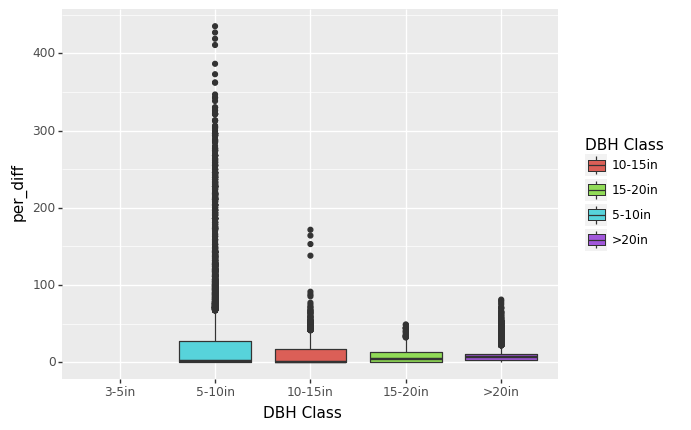

<ggplot: (184372402732)>

In [84]:
# assign size classes: 3-5, 5-10, 10-15, 15-20, >20
conditions = [(qa['DIA'] < 5),
              (qa['DIA'] >= 5) & (qa['DIA'] < 10),
              (qa['DIA'] >= 10) & (qa['DIA'] <= 15), 
              (qa['DIA'] >= 15) & (qa['DIA'] <= 20), 
              (qa['DIA'] >= 20)]

values = ['3-5in', '5-10in', '10-15in', '15-20in', '>20in']

qa["DBH Class"] = np.select(conditions, values)
qa=qa.sort_values(by=['DIA'])

(p9.ggplot(qa, aes(x = 'DBH Class', y ='per_diff', fill='DBH Class' ))
    + p9.geom_boxplot()
    + p9.scale_x_discrete(limits = ('3-5in', '5-10in', '10-15in', '15-20in', '>20in')))

In [137]:
# (p9.ggplot(qa, aes(x = 'DBH Class', y ='per_diff', fill='DBH Class' ))
#     + p9.geom_boxplot()
#     + p9.scale_x_discrete(limits = ('3-5in', '5-10in', '10-15in', '15-20in', '>20in'))
#     + p9.scale_y_continuous(limits = (0, 100)))

Do some exploration of how FVS calculates Mort and Acc values.
Run several FIA conditions through FVS.

In [183]:
#read in FVS output
DB_PATH = 'C:/FVS/FVS_Calibration_test/FVSOut.db'
con2 = sqlite3.connect(DB_PATH)
# grab summary, tree, and cases tables
fvs_summary = pd.read_sql_query("select CaseID, StandID, Year, Tpa, TCuFt, MCuFt, Mort, Acc from FVS_Summary2", con2)
fvs_trees = pd.read_sql_query("select StandID, Year, TreeId, SpeciesFIA, TreeVal, DBH, Ht, TCuFt, MCuFt from FVS_TreeList", con2)
fvs_cases = pd.read_sql_query("select CaseID, Stand_CN, StandID from FVS_Cases", con2)

In [184]:
#add stand_cn to summary for later joins to FIA data
summ = fvs_summary.merge(fvs_cases, how='inner', on=['CaseID', 'StandID'])
#remove stands with not trees, filter to first year only
summ = summ.loc[(summ['Tpa'] > 0) & (summ['Year']== 2001)]
#filter tree records to summ stands
summ_id = summ[['StandID', 'Year', 'Stand_CN']]
summ_trees = fvs_trees.merge(summ_id, how='inner', on=['StandID', 'Year'])

In [185]:
# sum volmes of dead and live trees by stand_cn
summ_agg = summ_trees.groupby(['Stand_CN', 'TreeVal'], as_index=False).agg({'TCuFt': 'sum'}).rename(columns={'TCuFt': 'sum_tcuft'})
summ_agg['sum_tcuft_year'] = summ_agg['sum_tcuft']/10

In [186]:
# check summ (fvs output) out to see how mort and acc compare to treelist sums
summ_join = summ.merge(summ_agg, how='inner', on='Stand_CN')
summ_mort = summ_join.loc[(summ_join['TreeVal']== 9)]
summ_acc = summ_join.loc[(summ_join['TreeVal']== 1)]

summ_acc['vol_per_diff'] = abs(summ_acc['Acc'] - summ_acc['sum_tcuft_year'])/summ_acc['Acc']*100
summ_acc['type'] = 'Live Trees'
summ_mort['vol_per_diff'] = abs(summ_mort['Mort'] - summ_mort['sum_tcuft_year'])/summ_mort['Mort']*100
summ_mort['type'] = 'Dead Trees'

summ_join = pd.concat([summ_acc, summ_mort])
summ_join

,CaseID,StandID,Year,Tpa,TCuFt,MCuFt,Mort,Acc,Stand_CN,TreeVal,sum_tcuft,sum_tcuft_year,vol_per_diff,type
0,57828de3-2a02-4b93-b5ea-a3b3fe6264ba,00062001050101023530221,2001,1090.642334,8145.525391,4116.272949,15.130357,248.907730,23664564010900,1,2704.772791,270.477279,8.665681,Live Trees
2,18a858e2-0602-451f-8da3-e5965bb889ce,00062001050101023593801,2001,332.043762,4386.397949,1873.369141,7.250462,166.519058,23666637010900,1,409.519441,40.951944,75.407053,Live Trees
4,1fe0102a-2e8d-4431-a720-39af65eb64d7,00062001050101023593803,2001,208.224548,9591.979492,7892.025391,231.158218,158.933899,23666644010900,1,1241.584225,124.158423,21.880465,Live Trees
5,b2b4d94d-15a0-4cf2-92da-214cd0eae1ef,00062001050101023755191,2001,335.247864,2450.515625,1905.172119,0.844305,119.503616,23664401010900,1,1020.700018,102.070002,14.588357,Live Trees
7,5da13935-6493-476a-b0b7-839b693f72d8,00062001050101023755192,2001,585.456421,1513.321533,1174.821655,0.140604,155.367477,23664403010900,1,62.400000,6.240000,95.983715,Live Trees
9,fb78c723-227b-4281-84a2-0faa666a2ce3,00062001050101045856871,2001,195.213898,1127.581055,552.046326,0.068396,62.255096,23687300010900,1,785.060318,78.506032,26.103783,Live Trees
1,57828de3-2a02-4b93-b5ea-a3b3fe6264ba,00062001050101023530221,2001,1090.642334,8145.525391,4116.272949,15.130357,248.907730,23664564010900,9,313.115929,31.311593,106.945502,Dead Trees
3,18a858e2-0602-451f-8da3-e5965bb889ce,00062001050101023593801,2001,332.043762,4386.397949,1873.369141,7.250462,166.519058,23666637010900,9,38.075064,3.807506,47.486014,Dead Trees
6,b2b4d94d-15a0-4cf2-92da-214cd0eae1ef,00062001050101023755191,2001,335.247864,2450.515625,1905.172119,0.844305,119.503616,23664401010900,9,60.869934,6.086993,620.947134,Dead Trees
8,5da13935-6493-476a-b0b7-839b693f72d8,00062001050101023755192,2001,585.456421,1513.321533,1174.821655,0.140604,155.367477,23664403010900,9,3.614210,0.361421,157.048096,Dead Trees


Now let's compare FIA individual tree volume estimates with FVS

In [190]:
vol_compare = trees_id.merge(summ_trees, how='left', left_on=['CN'], right_on=['Stand_CN'])
#vol_compare = vol_compare.loc[(vol_compare['INVYR'] == 2001) | (vol_compare['INVYR'] == 2010)]

In [192]:
vol_compare['INVYR'].unique()

array([1994, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)